In [1]:
!pip install langgraph langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 8.8 MB/s eta 0:00:00


In [2]:
!pip install langchain langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.6 MB/s eta 0:00:00


In [3]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00


In [4]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=094aabecd14d39ad5ed10896ec8e6579dbdff8744620fd080d534059de655a96
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [5]:
pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.5 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=a83f7bac22d6da37bce2894e4eaea72dda73a240273f817e45e58be79744ebc2
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [6]:
from typing import Annotated
from typing_extensions import TypedDict

### Working with the tools

In [7]:
from langchain.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain.tools import ArxivQueryRun,WikipediaQueryRun

### Calling the tools

In [8]:
Arxiv_Wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=500)
Arxiv_tool=ArxivQueryRun(api_wrapper=Arxiv_Wrapper)

Wikipedia_Wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
Wikipedia_tool=WikipediaQueryRun(api_wrapper=Wikipedia_Wrapper)

In [9]:
Wikipedia_tool.invoke("what is silicon valley?")

'Page: Silicon Valley\nSummary: Silicon Valley is a region in Northern California that is a global center for high technology and innovation. Located in the southern part of the San Francisco Bay Area, it corresponds roughly to the geographical area of the Santa Clara Valley. The term "Silicon Valley" refers to the area in which high-tech business has proliferated in Northern California, and it also serves as a general metonym for California\'s high-tech business sector.\nThe cities of Sunnyvale, Mo'

In [10]:
Arxiv_tool.invoke("yolo")

'Published: 2025-02-21\nTitle: YOLOv12 to Its Genesis: A Decadal and Comprehensive Review of The You Only Look Once (YOLO) Series\nAuthors: Ranjan Sapkota, Rizwan Qureshi, Marco Flores Calero, Chetan Badjugar, Upesh Nepal, Alwin Poulose, Peter Zeno, Uday Bhanu Prakash Vaddevolu, Sheheryar Khan, Maged Shoman, Hong Yan, Manoj Karkee\nSummary: This review systematically examines the progression of the You Only Look Once\n(YOLO) object detection algorithms from YOLOv1 to the recently unveiled\nYOLOv12. Em'

In [11]:
tools=[Arxiv_tool,Wikipedia_tool]

###Langgraph application

In [12]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [13]:
from langgraph.graph import StateGraph,START,END

In [14]:
graph_builder=StateGraph(State)

In [15]:
from langchain_groq import ChatGroq

In [16]:
from google.colab import userdata
groq_api_key=userdata.get("groq_api_key")

In [17]:
llm=ChatGroq(api_key=groq_api_key,model_name="meta-llama/llama-4-maverick-17b-128e-instruct")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7aaafa283d10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7aaaf9ef0990>, model_name='meta-llama/llama-4-maverick-17b-128e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [18]:
llm_with_tools=llm.bind_tools(tools=tools)

In [19]:
def chatbot(state:State):
  return{"messages":llm_with_tools.invoke(state["messages"])}

In [20]:
from langgraph.prebuilt import ToolNode,tools_condition

In [21]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [22]:
graph=graph_builder.compile()

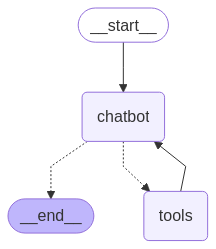

In [23]:
graph

In [24]:
user_input="Hi,what is silicon valley"
events=graph.stream({"messages":[("user",user_input)]},stream_mode="values")
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi,what is silicon valley
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_n2c1)
 Call ID: call_n2c1
  Args:
    query: Silicon Valley
================================= Tool Message =================================
Name: wikipedia

Page: Silicon Valley
Summary: Silicon Valley is a region in Northern California that is a global center for high technology and innovation. Located in the southern part of the San Francisco Bay Area, it corresponds roughly to the geographical area of the Santa Clara Valley. The term "Silicon Valley" refers to the area in which high-tech business has proliferated in Northern California, and it also serves as a general metonym for California's high-tech business sector.
The cities of Sunnyvale, Mo
================================== Ai Message ==================================

Silicon Valley is a region in Northern C